# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transform = [transforms.RandomRotation(15), transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), 
                   transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

test_transform = [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor(), 
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

# Download entire Training dataset (rename to 'dataset'), before dividing again to 
# training and cross validation sets
dataset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR_10_data/', train = True, 
                                        transform = transforms.Compose(train_transform), download = True)
datasize = len(dataset)

# Create randam array for training and validation sampling
indices = np.random.permutation(datasize) 

# Use 20% of the data to create the Validation data, 80% will be in Testing data
validsize = int(datasize * 0.2) 
v_idx, t_idx = indices[:validsize], indices[validsize:] 

# Divide to get trainset and validation set
trainset = torch.utils.data.dataset.Subset(dataset, t_idx)
validset = torch.utils.data.dataset.Subset(dataset, v_idx)

# Define train and validation dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64)
validloader = torch.utils.data.DataLoader(validset, batch_size=64)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR_10_data/', train = False, 
                                       transform = transforms.Compose(test_transform), download = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
print(f"Length of Training Set:\t\t {len(trainset)}")
print(f"Length of Validation Set:\t {len(validset)}")
print(f"Length of Testing Set:\t\t {len(testset)}")

Length of Training Set:		 40000
Length of Validation Set:	 10000
Length of Testing Set:		 10000


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        std = (0.485, 0.456, 0.406)
        mean = (0.229, 0.224, 0.225)
        for i in range(3):
            image = std[i] * image + mean[i]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

cat


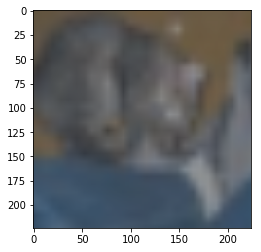

ship


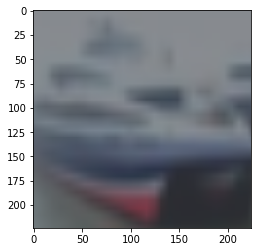

ship


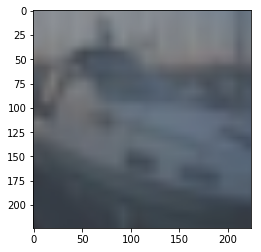

plane


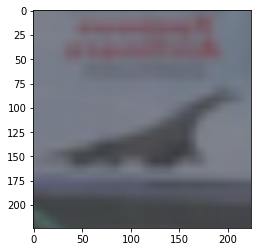

frog


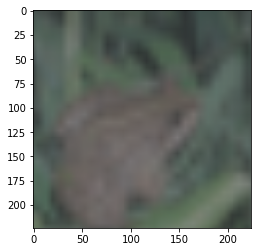

In [5]:
# Printing 5 images from test set
show5(testloader)

In [6]:
# Function to print the size or shape of the data

def tens_shape(img_loader):
    dataiter = iter(img_loader)
    images, labels = dataiter.next()
    print(f"Images: {images.shape}")
    print(f"Labels: {labels.shape}")

In [7]:
# Print the size or shape of the training data

print("Train Loader Shape")
tens_shape(trainloader)
print("\nValidation Loader Shape")
tens_shape(validloader)
print("\nTest Loader Shape")
tens_shape(testloader)

Train Loader Shape
Images: torch.Size([64, 3, 224, 224])
Labels: torch.Size([64])

Validation Loader Shape
Images: torch.Size([64, 3, 224, 224])
Labels: torch.Size([64])

Test Loader Shape
Images: torch.Size([64, 3, 224, 224])
Labels: torch.Size([64])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [8]:
model = torchvision.models.vgg11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.torch/models/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [00:05<00:00, 100956893.45it/s]


In [9]:
# Import Ordered Dict module
from collections import OrderedDict

# Freeze parameters so we don't backpropagate through them
for param in model.parameters():
    param.requires_grad = False

# Create ordered dictionary defining the new classifier
classifier = nn.Sequential(OrderedDict([
    ('0', nn.Linear(25088, 1200)),
    ('1', nn.ReLU()),
    ('2', nn.Dropout(p=0.4)),
    ('3', nn.Linear(1200,10)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.classifier = classifier

# Inspect new model architecture
print(model)    

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
# Moving to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [12]:
Train_loss, Train_accuracy, Validation_loss, Validation_accuracy = [],[],[],[]
_ta = []

epochs = 12 
train_loss = 0
batches = 250

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        # Calculate running training accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        train_accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        _ta.append(train_accuracy)
        
        if i % batches == 0:
            validation_loss = 0
            validation_accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    validation_loss += batch_loss.item()
                    
                    # Calculate running validation accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    validation_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the running training loss, validation loss, training accuracy and validation accuracy       
            tl = train_loss/batches
            vl = validation_loss/len(validloader)
            ta = sum(_ta)/len(_ta)
            va = validation_accuracy/len(validloader)
            
            Train_loss.append(tl)
            Validation_loss.append(vl) 
            Train_accuracy.append(ta)
            Validation_accuracy.append(va)
            
            print(f"Epoch: {epoch+1}/{epochs} .. "
                  f"Train Loss: {tl:.3f} .. "
                  f"Validation Loss: {vl:.3f} .. "
                  f"Train Accuracy: {ta:.3f} .. "
                  f"Validation Accuracy: {va:.3f}")            
            
            train_loss = 0
            model.train()

Epoch: 1/12 .. Train Loss: 1.634 .. Validation Loss: 1.353 .. Train Accuracy: 0.432 .. Validation Accuracy: 0.524
Epoch: 1/12 .. Train Loss: 1.287 .. Validation Loss: 1.188 .. Train Accuracy: 0.487 .. Validation Accuracy: 0.586
Epoch: 2/12 .. Train Loss: 1.755 .. Validation Loss: 1.115 .. Train Accuracy: 0.529 .. Validation Accuracy: 0.602
Epoch: 2/12 .. Train Loss: 1.123 .. Validation Loss: 1.083 .. Train Accuracy: 0.545 .. Validation Accuracy: 0.618
Epoch: 3/12 .. Train Loss: 1.611 .. Validation Loss: 1.053 .. Train Accuracy: 0.564 .. Validation Accuracy: 0.625
Epoch: 3/12 .. Train Loss: 1.078 .. Validation Loss: 1.037 .. Train Accuracy: 0.572 .. Validation Accuracy: 0.637
Epoch: 4/12 .. Train Loss: 1.556 .. Validation Loss: 1.035 .. Train Accuracy: 0.582 .. Validation Accuracy: 0.634
Epoch: 4/12 .. Train Loss: 1.039 .. Validation Loss: 1.011 .. Train Accuracy: 0.587 .. Validation Accuracy: 0.637
Epoch: 5/12 .. Train Loss: 1.510 .. Validation Loss: 1.000 .. Train Accuracy: 0.595 .. V

Plot the training loss (and validation loss/accuracy, if recorded).

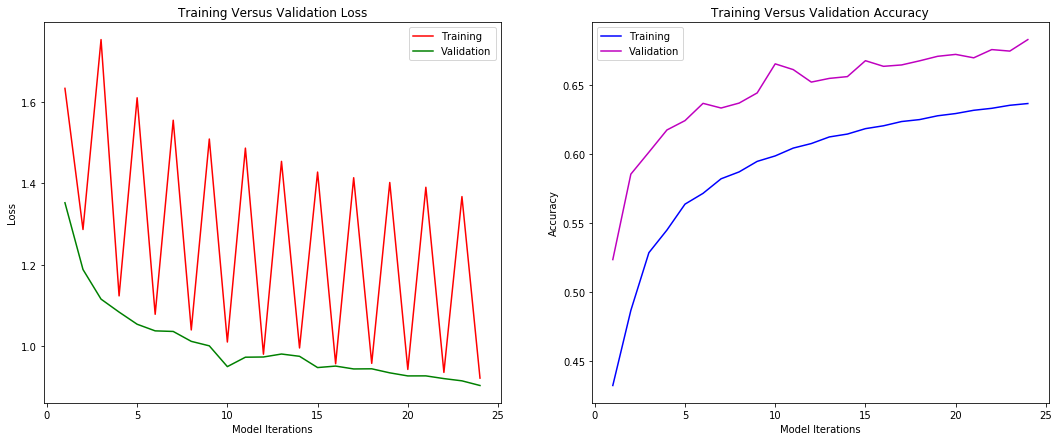

In [13]:
x = range(1, len(Train_loss) + 1)

fig = plt.figure()

plt.subplot(121)
plt.plot(x, Train_loss, label = 'Training', color='r')
plt.plot(x, Validation_loss, label = 'Validation', color='g') 
plt.xlabel('Model Iterations')
plt.ylabel('Loss')
plt.title('Training Versus Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(x, Train_accuracy, label = 'Training', color='b')
plt.plot(x, Validation_accuracy, label = 'Validation', color='m') 
plt.xlabel('Model Iterations')
plt.ylabel('Accuracy')
plt.title('Training Versus Validation Accuracy')
plt.legend()

fig.set_size_inches(18, 7)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
accuracy = 0
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        ps = torch.exp(logps)
        top_p, top_c = ps.topk(1, dim=1)
        equals = top_c == labels.view(*top_c.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    acc_perc = accuracy/len(testloader)
print(f"Accuracy: {acc_perc:.3f}")

if accuracy/len(testloader) < 0.45:
    print('Accuracy too low')
if accuracy/len(testloader) > 0.7:
        print('Accuracy within good range')

Accuracy: 0.853
Accuracy within good range


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
epochs = 12
learn_rate = 0.01

checkpoint = {'epochs': epochs,
              'learning_rate': learn_rate,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**How my model compares to Detectocorp's model.**

While Detectocorp's model has a 70% accuracy, my model is 85.3% accurate at classifying the CIFAR-10 dataset. For this reason, I recommend that we build our own model in-house.

**How my model compares to the far more advanced solutions in the literature.**

The final model presented is actually one of the earlier models I developed with the data. Out of the family of VGG models, VGG-11 (as used here) has the simplest architecture, with the lowest number of connected layers. Yet when the data was applied to VGG-16 as well as Resnet-18, I was unable to get accuracy of greater than 40% - so in my opinion an accuracy of 85.3% with a basic model is good. 

**What I did to get the accuracy I achieved.**

In the process of optimising VGG-11, I varied the learning rate from 0.1 to 0.001 while re-training. Eventually I settled on 0.01 as this provided better accuracy than both 0.1 and 0.001. I can only conclude that a learning rate of 0.1 scaled the error too much in the backpropagation step, while 0.001 was not enough. 

Similarly, I also tried training VGG-11 with both the stochastic gradient descent (SGD), as well as the Adam optimizer. While many examples (eg [[1]](https://arxiv.org/abs/1412.6980)) indicate that Adam is supposed to be an improvement on SGD, this was not my finding at all. With Adam I was only able to attain an accuracy around 40%. 

I also trained the network for 5, 8 and 12 epochs - 5 was not enough to get to the accuracy needed, but with 8 good gains were shown and then this was fine-tuned at 12 epochs. I feel the model is capable of achieving well over 90% accuracy if left for 20 epochs, however 85.3% is sufficient at this point to make a recommendation.

**Is it necessary to improve the accuracy and if so, what sort of work would be involved in improving it.**

Although it is not absolutely necessary to improve on an 85.3% accuracy, obviously it would be better to get the accuracy to around 90-95% without overfitting the network. 85.3% is a vast improvement on the 70% offered by Detectocorp, but in order to improve the accuracy I would need to go back to the more complex models and start troubleshooting on why the accuracy they provided was far lower than VGG-11. 

While VGG-16 and Resnet-18 were tested with a few learning rate and optimizer combinations, possibly running them over a higher number of epochs would lead to the required accuracy improvements. 

Finally, if the above proves not to be a viable solution, I could also train and validate the current model for 20 or more epochs as well to improve the current accuracy further (as previously mentioned).

### Reference
[[1]](https://arxiv.org/abs/1412.6980) Adam: A Method for Stochastic Optimization (2014).